Data Preprocessing

In [262]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Data Cleaning and Normalization for the new dataset
def preprocess_data(df, product_name):
    """
    Preprocess data for a single product:
    - Filters product-specific data
    - Sorts by year and week number
    - Normalizes TotalQuantity
    """
    # Filter data for selected product
    product_df = df[df['Product_Name'] == product_name].copy()

    # Sort by Year THEN WeekNumber
    product_df = product_df.sort_values(['Year', 'Week_Number']).reset_index(drop=True)

    # Extract TotalQuantity as numpy array
    data = product_df['Total_Quantity'].values.reshape(-1, 1)

    # Handle missing values
    data = np.nan_to_num(data)

    # Normalize between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, product_df, data



# 2. Create supervised learning dataset USING SCALED DATA
def create_dataset(scaled_data, time_steps=12):
    """
    Creates sequences of data for LSTM input:
    - X: past time steps
    - y: next step prediction target
    """

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:(i + time_steps), 0])  # take past demand
        y.append(scaled_data[i + time_steps, 0])      # predict next demand
    X = np.array(X)
    y = np.array(y)
    return X, y


In [265]:
# 1️⃣ Load dataset
file_path = "../data/demand_prediction_weekly.xlsx"
df = pd.read_excel(file_path)
df.head()


,Product_Name,Week,Year,Week_Number,Total_Quantity
0,CLINMISKIN GEL*,2021-W47,2021,47,1
1,CLINMISKIN GEL*,2021-W48,2021,48,2
2,CLINMISKIN GEL*,2021-W50,2021,50,2
3,CLINMISKIN GEL*,2021-W51,2021,51,1
4,CLINMISKIN GEL*,2022-W01,2022,1,1


In [266]:
scaled_data, scaler, product_df , data = preprocess_data(df, "TIBRIO")
print("scaled data",scaled_data,"/n")
print("scaler",scaler,"/n")
print(product_df)
print(data)

scaled data [[0.04225352]
 [0.07042254]
 [0.15492958]
 [0.21126761]
 [0.26760563]
 [0.21126761]
 [0.04225352]
 [0.21126761]
 [0.15492958]
 [0.07042254]
 [0.23943662]
 [0.12676056]
 [0.02816901]
 [0.23943662]
 [0.04225352]
 [0.12676056]
 [0.07042254]
 [0.04225352]
 [0.07042254]
 [0.21126761]
 [0.21126761]
 [0.12676056]
 [0.15492958]
 [0.07042254]
 [0.07042254]
 [0.07042254]
 [0.04225352]
 [0.04225352]
 [0.07042254]
 [0.07042254]
 [0.04225352]
 [0.07042254]
 [0.01408451]
 [0.07042254]
 [0.21126761]
 [0.32394366]
 [0.04225352]
 [0.23943662]
 [0.4084507 ]
 [0.09859155]
 [0.15492958]
 [0.07042254]
 [0.12676056]
 [0.07042254]
 [0.18309859]
 [0.07042254]
 [0.07042254]
 [0.4084507 ]
 [0.01408451]
 [0.12676056]
 [0.        ]
 [0.07042254]
 [0.07042254]
 [0.07042254]
 [0.12676056]
 [0.12676056]
 [0.08450704]
 [0.32394366]
 [0.15492958]
 [0.26760563]
 [0.07042254]
 [0.38028169]
 [0.15492958]
 [0.38028169]
 [0.21126761]
 [0.07042254]
 [0.07042254]
 [0.15492958]
 [0.02816901]
 [0.33802817]
 [0.0704

In [267]:
X, y =  create_dataset(scaled_data, time_steps=4) 
print(X,y)

[[0.04225352 0.07042254 0.15492958 0.21126761]
 [0.07042254 0.15492958 0.21126761 0.26760563]
 [0.15492958 0.21126761 0.26760563 0.21126761]
 [0.21126761 0.26760563 0.21126761 0.04225352]
 [0.26760563 0.21126761 0.04225352 0.21126761]
 [0.21126761 0.04225352 0.21126761 0.15492958]
 [0.04225352 0.21126761 0.15492958 0.07042254]
 [0.21126761 0.15492958 0.07042254 0.23943662]
 [0.15492958 0.07042254 0.23943662 0.12676056]
 [0.07042254 0.23943662 0.12676056 0.02816901]
 [0.23943662 0.12676056 0.02816901 0.23943662]
 [0.12676056 0.02816901 0.23943662 0.04225352]
 [0.02816901 0.23943662 0.04225352 0.12676056]
 [0.23943662 0.04225352 0.12676056 0.07042254]
 [0.04225352 0.12676056 0.07042254 0.04225352]
 [0.12676056 0.07042254 0.04225352 0.07042254]
 [0.07042254 0.04225352 0.07042254 0.21126761]
 [0.04225352 0.07042254 0.21126761 0.21126761]
 [0.07042254 0.21126761 0.21126761 0.12676056]
 [0.21126761 0.21126761 0.12676056 0.15492958]
 [0.21126761 0.12676056 0.15492958 0.07042254]
 [0.12676056 

In [268]:
print("Scaled data sample:", scaled_data[:10].flatten())
print("X sample:", X[0])
print("y sample:", y[0])
print("Original demand sample:", data[:10].flatten())


Scaled data sample: [0.04225352 0.07042254 0.15492958 0.21126761 0.26760563 0.21126761
 0.04225352 0.21126761 0.15492958 0.07042254]
X sample: [0.04225352 0.07042254 0.15492958 0.21126761]
y sample: 0.26760563380281693
Original demand sample: [ 4  6 12 16 20 16  4 16 12  6]


In [269]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(len(X))
print(X)

156
[[[0.04225352]
  [0.07042254]
  [0.15492958]
  [0.21126761]]

 [[0.07042254]
  [0.15492958]
  [0.21126761]
  [0.26760563]]

 [[0.15492958]
  [0.21126761]
  [0.26760563]
  [0.21126761]]

 [[0.21126761]
  [0.26760563]
  [0.21126761]
  [0.04225352]]

 [[0.26760563]
  [0.21126761]
  [0.04225352]
  [0.21126761]]

 [[0.21126761]
  [0.04225352]
  [0.21126761]
  [0.15492958]]

 [[0.04225352]
  [0.21126761]
  [0.15492958]
  [0.07042254]]

 [[0.21126761]
  [0.15492958]
  [0.07042254]
  [0.23943662]]

 [[0.15492958]
  [0.07042254]
  [0.23943662]
  [0.12676056]]

 [[0.07042254]
  [0.23943662]
  [0.12676056]
  [0.02816901]]

 [[0.23943662]
  [0.12676056]
  [0.02816901]
  [0.23943662]]

 [[0.12676056]
  [0.02816901]
  [0.23943662]
  [0.04225352]]

 [[0.02816901]
  [0.23943662]
  [0.04225352]
  [0.12676056]]

 [[0.23943662]
  [0.04225352]
  [0.12676056]
  [0.07042254]]

 [[0.04225352]
  [0.12676056]
  [0.07042254]
  [0.04225352]]

 [[0.12676056]
  [0.07042254]
  [0.04225352]
  [0.07042254]]

 [[0

In [270]:
print(X.shape)

(156, 4, 1)


Model Architecture Implementation

In [271]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

from tensorflow.keras.activations import relu, tanh, selu
from tensorflow.keras.optimizers import Adam

In [272]:

def create_multilayer_lstm_model(units=64, dropout_rate=0.0, activation=relu, 
                                optimizer=Adam(learning_rate=0.001), time_steps=2):
    """
    Build the multilayer LSTM model as described in the paper
    """
    model = Sequential()

    # Define the input layer explicitly
    model.add(Input(shape=(time_steps, 1)))
    
    # First LSTM layer with return_sequences=True for multilayer
    model.add(LSTM(units=64, 
                   return_sequences=True, 
                   #input_shape=(time_steps, 1),
                   activation=activation))
    model.add(Dropout(rate=dropout_rate))
    
    # Second LSTM layer (final layer with return_sequences=False)
    model.add(LSTM(units=units, 
                   return_sequences=False,
                   activation=activation))
    model.add(Dropout(rate=dropout_rate))
    

    #model.add(Dense(units=64, activation='relu'))

    # Dense output layer
    model.add(Dense(units=1))
    
     # Choose optimizer
    optimizer_dict = {
        'Adam': Adam(),
        'Adagrad': Adagrad(),
        'Adadelta': Adadelta(),
        'Adamax': Adamax(),
        'Nadam': Nadam()
    }

    
    # Compile model with MSE loss as mentioned in paper
    model.compile(optimizer=optimizer, loss='mse')
    
    return model


Evaluation Metrics

In [273]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate using RMSE and SMAPE as in the paper
    """
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE (equation 13)
    rmse = np.sqrt(np.mean((y_test_actual - predictions) ** 2))
    
    # Calculate SMAPE (equation 12)
    smape = np.mean(2 * np.abs(y_test_actual - predictions) / 
                   (np.abs(y_test_actual) + np.abs(predictions)))
    
    mae = mean_absolute_error(y_test_actual, predictions)
    accuracy = max(0, (1 - (mae / np.mean(y_test_actual))) * 100)

    return rmse, smape, predictions, y_test_actual, accuracy, mae


Complete Training Pipeline

In [ ]:
def train_pharmaceutical_lstm(sales_data, product_to_be_predicted):
    """
    Complete training pipeline following the paper's methodology
    """
    # Step 1: Preprocess data
    scaled_data, scaler, product_df, data = preprocess_data(sales_data, product_to_be_predicted)

    
    # Step 2: Create supervised learning dataset
    X, y = create_dataset(scaled_data, time_steps=2)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Step 3: Split data as described in paper
    # Training: Jan 2012 - July 2017
    # Testing: Aug 2017 - March 2019  
    # Validation: April 2019 - Dec 2020
    
    train_size = int(0.7 * len(X))
    test_size = int(0.85 * len(X))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:test_size], y[train_size:test_size]
    X_val, y_val = X[test_size:], y[test_size:]
    
    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    # Step 4: Build optimized model using best parameters from paper
    model = create_multilayer_lstm_model(
        units=64,
        dropout_rate=0.0,  # Best parameter from their grid search
        activation = relu,  # You may need to test this
        optimizer= Adam(learning_rate=1e-4),
        time_steps=2
    )
    
    # Step 5: Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=2,
        validation_data=(X_val, y_val),
        verbose=1,
        shuffle=False
    )

    rmse, smape, predictions, y_test_actual, accuracy, mae = evaluate_model(model, X_test, y_test, scaler)

    return model, scaler, history, rmse, smape, predictions, y_test_actual, accuracy, mae, X, y


train and plot demand forecasting

Available Medicines:
 ['CLINMISKIN GEL*' 'DESWIN  TAB' 'K GLIM-M 1MG' 'MEFORNIX P'
 'MONTEMAC FX TAB' 'MOXCLAV 625' 'PANTOP - 40  TAB' 'TELMIGET  40  TAB'
 'TIBRIO']
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0579 - val_loss: 0.2140
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - val_loss: 0.1991
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458 - val_loss: 0.1819
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - val_loss: 0.1634
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 - val_loss: 0.1437
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - val_loss: 0.1247
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - val_loss: 0.1087
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - val_loss: 0.0970
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 - val_loss: 0.0894
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - 

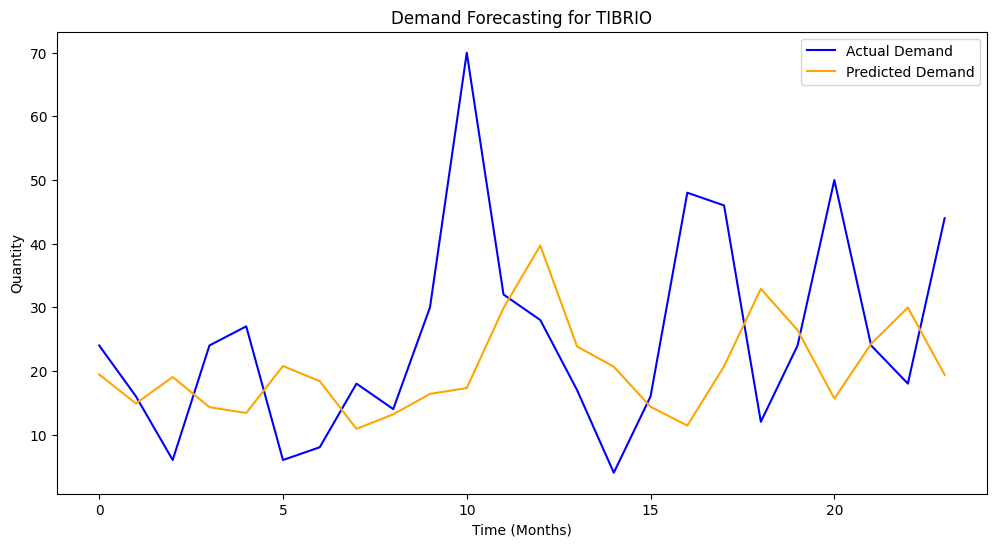

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


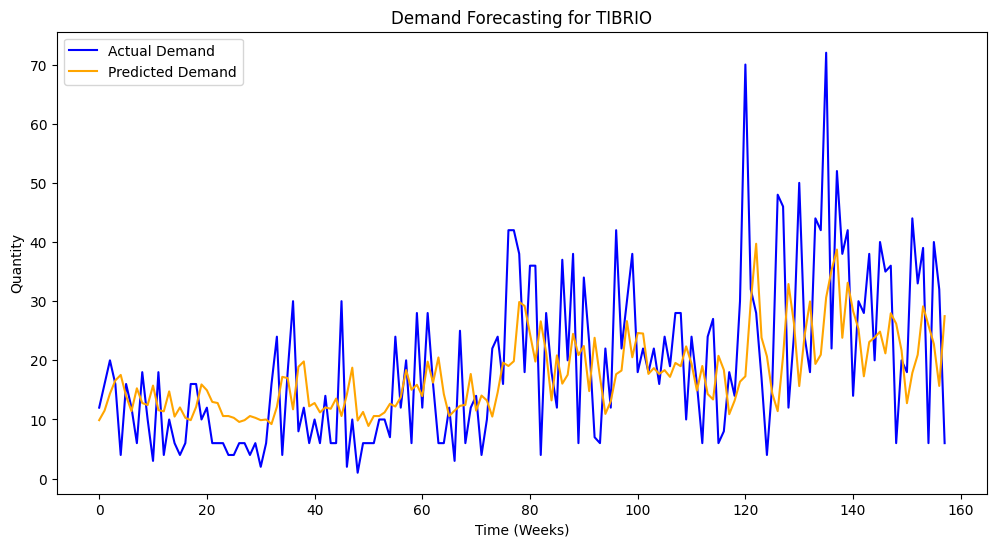

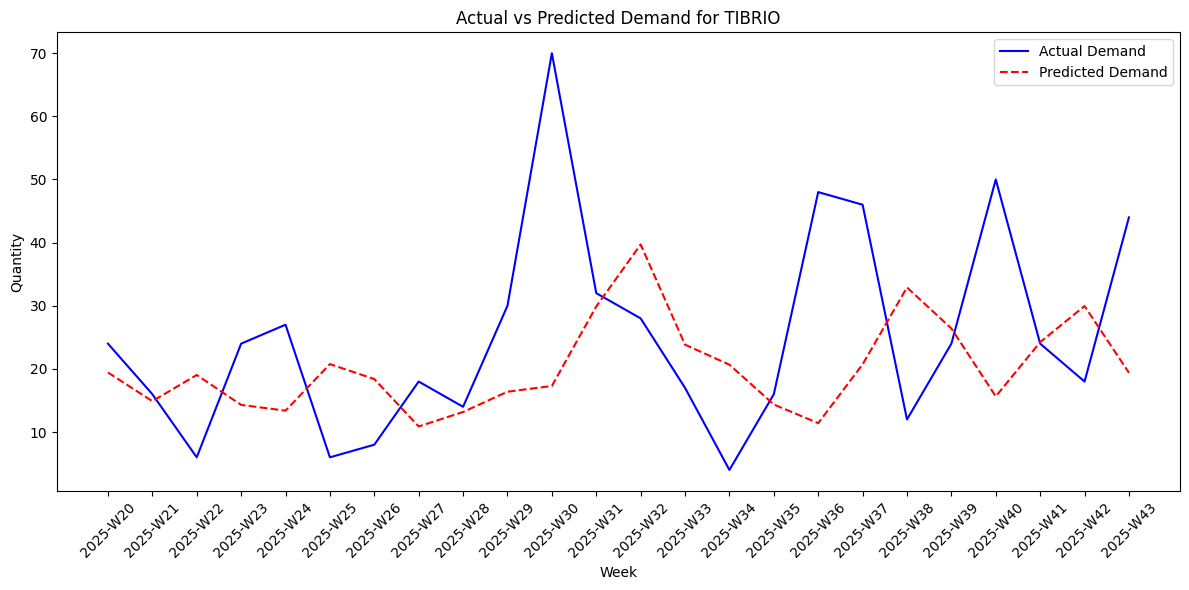

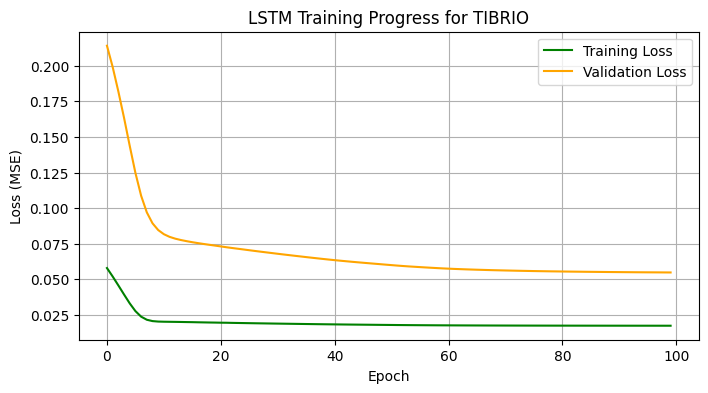

model summary:


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_109 (LSTM)                 │ (None, 2, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

history:
{'loss': [0.057946741580963135, 0.05203863978385925, 0.04577795788645744, 0.03938405215740204, 0.033155929297208786, 0.027724213898181915, 0.02383837103843689, 0.021664464846253395, 0.020724309608340263, 0.020392220467329025, 0.020281236618757248, 0.02022440917789936, 0.020169535651803017, 0.02010594680905342, 0.020032793283462524, 0.019971461966633797, 0.019881611689925194, 0.019807223230600357, 0.01973426342010498, 0.01967574656009674, 0.019599296152591705, 0.019557291641831398, 0.019466958940029144, 0.019399190321564674, 0.019331902265548706, 0.01926368661224842, 0.019199715927243233, 0.01913679763674736, 0.01907486282289028, 0.019014129415154457, 0.018954435363411903, 0.0188968013972044, 0.01883980631828308, 0.018781514838337898, 0.018725043162703514, 0.018667470663785934, 0.0186123326420784, 0.0185578353703022, 0.018505755811929703, 0.018456431105732918, 0.018409958109259605, 0.01836300455033779, 0.018318479880690575, 0.018275512382388115, 0.01823497749865055, 0.018196005

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
file_path = "../data/demand_prediction_weekly.xlsx"
sales_data = pd.read_excel(file_path)

# 2️⃣ Display available medicines
unique_medicines = sales_data['Product_Name'].unique()
print("Available Medicines:\n", unique_medicines)

# 3️⃣ Select medicine dynamically
selected_medicine = input("Enter the medicine name from the list above: ")

# 4️⃣ Train LSTM model (includes preprocessing + evaluation internally)
model, scaler, history, rmse, smape, predictions, y_test_actual, accuracy, mae, X, y = train_pharmaceutical_lstm(
    sales_data, selected_medicine
)

# 5️⃣ Print model performance
print(f"\n📊 Model Evaluation for {selected_medicine}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2%}")
print(f"✅ Accuracy (approx): {accuracy:.2f}%")
print(f"📉 Mean Absolute Error (MAE): {mae:.2f}")


# 6️⃣ Plot Actual vs Predicted Demand
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Demand', color='blue')
plt.plot(predictions, label='Predicted Demand', color='orange')
plt.title(f"Demand Forecasting for {selected_medicine}")
plt.xlabel("Time (Weeks)")
plt.ylabel("Quantity")
plt.legend()
plt.show()


predictions1 = scaler.inverse_transform(model.predict(X))
y1 = scaler.inverse_transform(y.reshape(-1, 1))

# Plot actual vs predicted demand ON WHOLE DATA
plt.figure(figsize=(12,6))
plt.plot(y1, label='Actual Demand', color='blue')
plt.plot(predictions1, label='Predicted Demand', color='orange')
plt.title(f"Demand Forecasting for {selected_medicine}")
plt.xlabel("Time (Weeks)")
plt.ylabel("Quantity")
plt.legend()
plt.show()

# Assuming len(y_true) == len(product_df) - time_steps
time_labels = product_df['Week'].iloc[-len(y_test_actual):]

plt.figure(figsize=(12, 6))
plt.plot(time_labels, y_test_actual, label='Actual Demand', color='blue')
plt.plot(time_labels, predictions, label='Predicted Demand', color='red', linestyle='--')
plt.title(f"Actual vs Predicted Demand for {selected_medicine}")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# 7️⃣ Plot Training & Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f"LSTM Training Progress for {selected_medicine}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


print("model summary:")
model.summary()

print("history:")
print(history.history)


model saving

In [ ]:
#model.save("../saved models/pharma_lstm_model.keras")


Fine tuning

In [260]:
from tensorflow.keras.models import load_model

model = load_model("../saved models/good.keras")

In [261]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",  # adjust if using something else
    metrics=["mae"]
)

In [ ]:
model.fit(
    train_dataset,               # your training dataset
    epochs=5,                    # fewer epochs for fine-tuning
    validation_data=(X_val, y_val)  # optional validation data
)